# Decoding QR codes using neural networks

In this example, a neural network (NN) will decode QR codes with the text being up to 11 characters long.

It is worth mentioning that using neural networks for QR decoding is not an optimal approach. There are well defined and simple algorithms to achieve these tasks. At the same time, due to ease of training data collection, QR codes provide a good practical experience for building NNs.

Decoding a QR code may be defined as a classification task. The result is a combination of outputs of eleven classifiers, one for each position. Each classifier tries to predict a symbol for a given spot. If an encoded text is shorter than eleven characters, a special symbol end-of-input (EOI) should be produced for empty positions. In this particular example, all texts are lowercase characters a..z and space. The total number of classes to be predicted is 28, which is 26 letter classes, one for space and one for EOI. For example, a string 'hello' may be represented by classes: 'h', 'e', 'l', 'l', 'o', '#', '#', '#', '#', '#', '#'. As a minor optimization, a working example could abandon symbols classification as soon as EOI class is detected since it is by definition that EOI may show up only at the end of the output.

p.s.
Why is the supported size up to 11 characters (and not 10 for example)? This is to be able to decode the 'hello world'.

## 1. Initialization
To run the example, the latest Anaconda distribution is used. It comes with all the main libraries. QR code library has to be installed via Anaconda package manager - "r-qrcode" is the package to add.

In [1]:
# import all required libraries

import random
import string
import qrcode

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

# the next two lines fix a runtime bug on mac os
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

As it was mentioned above, input texts are up to eleven characters long. An input may contain lower case letters and spaces. End-of-input is a special class to assign to empty positions. Below are definitions for constants used to build and train NNs.

In [2]:
LETTERS = string.ascii_lowercase + ' ' # letters and space
EOI = '#' # end of input
MAX_SIZE = 11 # max input/output size
ALL_CHAR_CLASSES = LETTERS + EOI # all available classes

In [3]:
# define a function for a QR code generation
# box_size is an option to manage size of an output image
def make_qr(text, box_size = 1):
    qr = qrcode.QRCode(
    version=1,
    box_size=box_size,
    border=0)
    qr.add_data(text)
    qr.make(fit=True)
    return qr.make_image(fill_color="black", back_color="white")

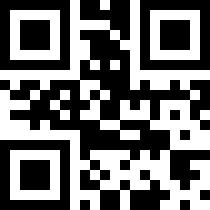

In [4]:
# generate a sample image
make_qr("hello world", box_size=10)

In the above example, the box size is set to 10 to make details of the image look larger. It makes sense to minimize the size of an image being fed into an NN. To do so, all QR codes below are using a box size of 1. The size of the generated images is 21x21 pixels.

In [5]:
print('FFNN input size is', make_qr("hello world").size)

FFNN input size is (21, 21)


The training data set needs to be generated. The function below creates a given number of examples with length constraints.

The output is uniformly distributed. This applies to both sizes and characters in texts.

The output contains a NumPy array of all images and corresponding texts. Image data is already formatted to be fed to a NN. The output texts will be converted to the required format on the go.

In [6]:
# a function to generate a train data set
# output: (numpy array of images, list of corresponding texts)
def generate_dataset(n_of_samples, min_size = 1, max_size = 11):
    data = []
    labels = []
    report_step = int(n_of_samples * .1)
    report = report_step
    print("Generating")
    for i in range(n_of_samples):
        if i == report:
            print("Done:", report / report_step * 10, "%")
            report = report + report_step
        size = random.randint(min_size, max_size)
        s = ''.join(random.choice(LETTERS) for i in range(size))
        img = make_qr(s)
        assert img.size == (21, 21)
        qr = np.asarray(img, dtype='float')
        data.append(qr)
        labels.append(s)
    print("Done:", "100", "%")
    return (np.asarray(data), labels)

The training set is 50k. This is an arbitrary number. It was chosen for code to be relatively fast on an average laptop. But, of course, a larger data set will lead to better accuracy.

In [7]:
(training_data, training_labels) = generate_dataset(50000)

Generating
Done: 10.0 %
Done: 20.0 %
Done: 30.0 %
Done: 40.0 %
Done: 50.0 %
Done: 60.0 %
Done: 70.0 %
Done: 80.0 %
Done: 90.0 %
Done: 100 %


## 2. Building a feed-forward neural network (FFNN) to estimate encoded text size

To get the ball rolling, the first FFNN will extract a text length from a QR image. This problem may be defined as a classification one. The input is a QR image. The output is one of 11 classes, one for each possible size. 

The training set already has all the QR images. Size labels should be created based on original texts:

In [9]:
# create a list of sizes based on original text labels
training_label_sizes = list(map(lambda x: [len(x) - 1], training_labels))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe5f453a90>]],
      dtype=object)

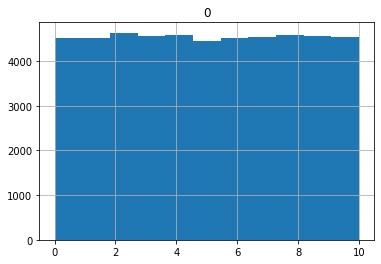

In [11]:
# confirm sizes are uniformly distributed
sizes_frame = pd.DataFrame(training_label_sizes)
sizes_frame.hist(bins=11)

As expected, sizes are uniformly distributed.

Define first NN classifier with a single hidden layer:

In [12]:
size_classifier = keras.Sequential([
    keras.layers.Flatten(input_shape=(21, 21)), # all input images are 21x21 pixels
    keras.layers.Dense(21*21, activation='relu'), # set hidden layer to the same size as the input
    keras.layers.Dense(MAX_SIZE) # output size is equal to number of classes, one for each size
])

size_classifier.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

size_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 441)               0         
_________________________________________________________________
dense (Dense)                (None, 441)               194922    
_________________________________________________________________
dense_1 (Dense)              (None, 11)                4862      
Total params: 199,784
Trainable params: 199,784
Non-trainable params: 0
_________________________________________________________________


Time to train the network. The validation split is set to 5%, which gives 2.5k of validation samples. Since the original data is randomly generated, there is no need to re-shuffle.

The early stop is based on validation loss. There is no saving for the best model, as this is an exploration run.

Train on 47500 samples, validate on 2500 samples
Epoch 1/30
47500/47500 [==============================] - 3s 56us/sample - loss: 0.4086 - accuracy: 0.9015 - val_loss: 0.0739 - val_accuracy: 0.9920
Epoch 2/30
47500/47500 [==============================] - 2s 45us/sample - loss: 0.0338 - accuracy: 0.9976 - val_loss: 0.0175 - val_accuracy: 1.0000
Epoch 3/30
47500/47500 [==============================] - 2s 47us/sample - loss: 0.0100 - accuracy: 0.9997 - val_loss: 0.0063 - val_accuracy: 1.0000
Epoch 4/30
47500/47500 [==============================] - 3s 57us/sample - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 5/30
47500/47500 [==============================] - 2s 52us/sample - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0018 - val_accuracy: 1.0000
Epoch 6/30
47500/47500 [==============================] - 2s 50us/sample - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/30
47500/47500 [==============================] -

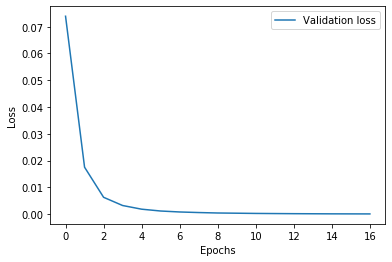

In [13]:
# train the size classifier
size_history = size_classifier.fit(
    training_data, np.asarray(training_label_sizes),
    epochs=30, batch_size=128,
    validation_split=0.05,
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=3)]
)

# plot the validation loss
plt.plot(size_history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

The training finished pretty fast and the validation accuracy is 1.

It is worth running the classifier on a few examples:

In [14]:
# function to get a text size from a QR image using the pretrained NN
# the original NN is extended with a softmax layer
def get_size(qr_img):
        assert qr_img.size == (21, 21)
        qr = np.asarray(qr_img, dtype='float') # convert image to numpy array
        input = np.asarray([qr]) # NN takes a list of images as an input, make one item numpy array
        soft_max_model = keras.Sequential([size_classifier, keras.layers.Softmax()]) # make interpretation of classifier confidence easier
        output = soft_max_model.predict(input) # softmax returns a distribution of probabilities for each size
        largest_index = np.argmax(output[0], axis=0) # get an index of largest probability
        print("Size", largest_index + 1, ", confidence", output[0][largest_index])
        
test_set = [
    'x',
    'yo',
    'ham',
    'four',
    'f ive',
    'sixsix',
    'seven z',
    'ei ght x',
    'nine hops',
    'ten strike',
    'hello world'
]

for t in test_set:
    get_size(make_qr(t))

Size 1 , confidence 0.9999956
Size 2 , confidence 0.9999944
Size 3 , confidence 0.9999914
Size 4 , confidence 0.99998057
Size 5 , confidence 0.9999546
Size 6 , confidence 0.99999034
Size 7 , confidence 0.9999995
Size 8 , confidence 0.9999913
Size 9 , confidence 0.9998647
Size 10 , confidence 0.99928135
Size 11 , confidence 0.99999785


All sizes are correct and confidence is at least three nines. This is a good result.

## 3. Exploring options by predicting the first and the last characters

NN for size prediction works very well. As the next step of exploration, we can move to character prediction. We start with the first and last characters to see how the model behaves.

Since the same structured networks are trained for different positions, it makes sense to define common functions:

In [15]:
# create training labels for existing texts and required position
def make_labels_for_position(labels, pos):
    chars = list(map(lambda x: x[pos] if pos < len(x) else EOI, labels)) # either a letter or EOI
    return list(map(lambda x: [ALL_CHAR_CLASSES.index(x)], chars)) # all classes are indexed [0..len(ALL_CHAR_CLASSES))

# define a simple model. Input is a QR image. Output is a character class.
# start with singel hidden layer.
def define_char_classifier():
    model = keras.Sequential([
        keras.layers.Flatten(input_shape=(21, 21)),
        keras.layers.Dense(21*21, activation='relu'),
        keras.layers.Dense(len(ALL_CHAR_CLASSES))
    ])
    
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

# train a model using common options
def train_model(model, data, labels, epochs=75, patience=3):
    return model.fit(
        data, np.asarray(labels),
        epochs=epochs, batch_size=128,
        validation_split=0.05,
        callbacks=[EarlyStopping(monitor='val_loss' , min_delta=0.0001, patience=patience)]
    )

# get an actual letter predicted by a model
# since there is one network per position, no need in position argument
# input is a QR image, output is a letter, for the position the model is trained for
def get_letter(qr_img, model):
        assert qr_img.size == (21, 21)
        qr = np.asarray(qr_img, dtype='float')
        input = np.asarray([qr]) # convert image to NN input
        output = model.predict(input) # get a vector of logits for each class
        largest_index = np.argmax(output[0], axis=0) # pick an index of most probable class
        c = ALL_CHAR_CLASSES[largest_index] # get the actual character
        return (c, output[0][largest_index], np.around(output,2)) # return character 


Start with the first letter:

In [16]:
# create train labels using the first character of every original text
training_labels_char0 = make_labels_for_position(training_labels, 0)
# create and train model
model = define_char_classifier()
model.summary()
hist0 = train_model(model, training_data, training_labels_char0)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 441)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 441)               194922    
_________________________________________________________________
dense_3 (Dense)              (None, 28)                12376     
Total params: 207,298
Trainable params: 207,298
Non-trainable params: 0
_________________________________________________________________
Train on 47500 samples, validate on 2500 samples
Epoch 1/75
47500/47500 [==============================] - 3s 59us/sample - loss: 2.8364 - accuracy: 0.1838 - val_loss: 2.2639 - val_accuracy: 0.2784
Epoch 2/75
47500/47500 [==============================] - 2s 46us/sample - loss: 1.6036 - accuracy: 0.4995 - val_loss: 0.9522 - val_accuracy: 0.7720
Epoch 3/75
47500/47500 [======

After a short training, validation accuracy is 1. Loss and validation loss are also close:

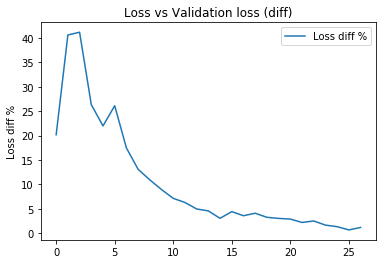

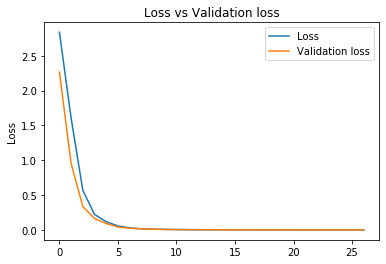

In [17]:
def plot_loss_vs_validation_loss_diff(train_history, abs_output = False):
    loss = np.asarray(train_history.history['loss'])
    val_loss = np.asarray(train_history.history['val_loss'])
    loss_diff = (loss - val_loss)/loss*100 # how much validation loss is different to loss
    if abs_output:
        loss_diff = np.abs(loss_diff)

    plt.plot(loss_diff, label='Loss diff %')
    plt.title('Loss vs Validation loss (diff)')
    plt.ylabel('Epochs')
    plt.ylabel('Loss diff %')
    plt.legend(loc="best")
    plt.show()
    
def plot_loss_vs_validation_loss(train_history, abs_output = False):
    plt.plot(np.asarray(train_history.history['loss']), label='Loss')
    plt.plot(np.asarray(train_history.history['val_loss']), label='Validation loss')
    plt.title('Loss vs Validation loss')
    plt.ylabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="best")
    plt.show()

plot_loss_vs_validation_loss_diff(hist0)
plot_loss_vs_validation_loss(hist0)

Let's apply the trained network to a few examples:

In [18]:
# function to try a text sample
# text is converted to a QR image, and then the network is predicting a character
def predict_letters_in_position(list_of_samples, model, postion):
    for t in list_of_samples:
        qr = make_qr(t)
        char_to_predict = t[postion] if len(t) > postion else '#'
        softmax_model = keras.Sequential([model, keras.layers.Softmax()])
        (c, confidence, _) = get_letter(qr, softmax_model)
        print(c == char_to_predict,
              'Expected:', char_to_predict,
              'Predicted:', c,
              'Input:', t,
              'Confidence:', confidence)

# use a text set used earlier
predict_letters_in_position(test_set, model, 0)

True Expected: x Predicted: x Input: x Confidence: 0.99999416
True Expected: y Predicted: y Input: yo Confidence: 0.99993885
True Expected: h Predicted: h Input: ham Confidence: 0.99992704
True Expected: f Predicted: f Input: four Confidence: 0.99985504
True Expected: f Predicted: f Input: f ive Confidence: 0.999928
True Expected: s Predicted: s Input: sixsix Confidence: 0.9997311
True Expected: s Predicted: s Input: seven z Confidence: 0.99991214
True Expected: e Predicted: e Input: ei ght x Confidence: 0.99977547
True Expected: n Predicted: n Input: nine hops Confidence: 0.9998703
True Expected: t Predicted: t Input: ten strike Confidence: 0.9998048
True Expected: h Predicted: h Input: hello world Confidence: 0.999866


Again, great accuracy and confidence.

Time to try the last character:

In [19]:
# create training labels from existing texts
training_labels_char10 = make_labels_for_position(training_labels, 10)
# build and train a model, and apply to text samples
model = define_char_classifier()
hist10 = train_model(model, training_data, training_labels_char10)
predict_letters_in_position(test_set, model, 10)

Train on 47500 samples, validate on 2500 samples
Epoch 1/75
47500/47500 [==============================] - 3s 60us/sample - loss: 0.4419 - accuracy: 0.9071 - val_loss: 0.2932 - val_accuracy: 0.9192
Epoch 2/75
47500/47500 [==============================] - 2s 46us/sample - loss: 0.3016 - accuracy: 0.9155 - val_loss: 0.2711 - val_accuracy: 0.9232
Epoch 3/75
47500/47500 [==============================] - 2s 53us/sample - loss: 0.2629 - accuracy: 0.9220 - val_loss: 0.2296 - val_accuracy: 0.9260
Epoch 4/75
47500/47500 [==============================] - 3s 57us/sample - loss: 0.2224 - accuracy: 0.9305 - val_loss: 0.1973 - val_accuracy: 0.9348
Epoch 5/75
47500/47500 [==============================] - 3s 57us/sample - loss: 0.1786 - accuracy: 0.9419 - val_loss: 0.1556 - val_accuracy: 0.9456
Epoch 6/75
47500/47500 [==============================] - 2s 51us/sample - loss: 0.1386 - accuracy: 0.9553 - val_loss: 0.1253 - val_accuracy: 0.9564
Epoch 7/75
47500/47500 [==============================] -

Validation accuracy seems good. Let's compare metrics for the first and the last characters:

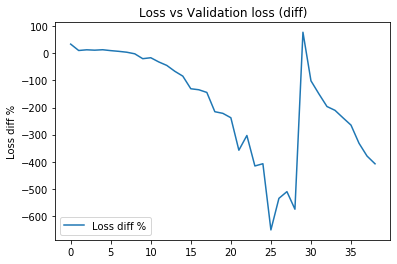

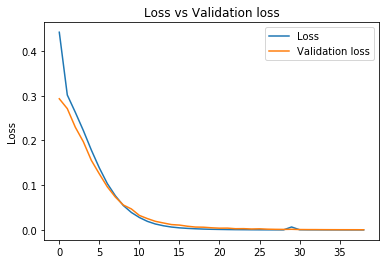

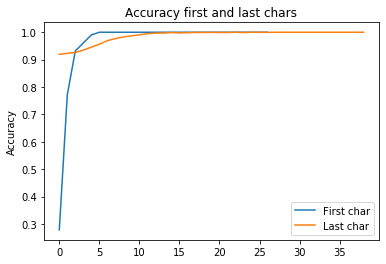

In [20]:
plot_loss_vs_validation_loss_diff(hist10)
plot_loss_vs_validation_loss(hist10)

plt.plot(hist0.history['val_accuracy'], label='First char')
plt.plot(hist10.history['val_accuracy'], label='Last char')
plt.title('Accuracy first and last chars')
plt.ylabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
axes = plt.gca()
plt.show()


Accuracy looks suspicious: from the very beginning, the accuracy for the last character is 90%! How so? Let's see how labels for the last character look like:

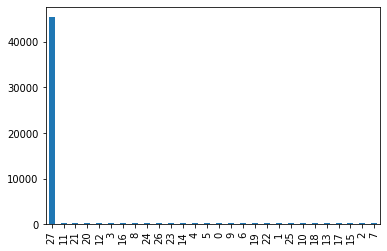

In [21]:
frame10 = pd.DataFrame(training_labels_char10)
frame10[0].value_counts().plot(kind='bar')

Hm. The graph shows the number of samples per character. Character class 27 completely dominates sample space.

In [22]:
# print 27th class
print("Character 27 is", ALL_CHAR_CLASSES[27])

Character 27 is #


So the most frequent last character is # - which is the end of input. This should make sense. Since our data is generated in a uniform random fashion, the data set has the same number of text for every length - 1 to 11. Every example with a length of less than 11 has EOI symbols at 11th position. This is a problem with the data, which leads to poor NN performance. From the NN point of view, just classifying every last character as EOD, already gives a high percentage of accuracy.

The second conclusion comes to the number of samples. For the first character, there are 50k uniformly distributed samples. But from the second character and up, the uniform distribution is no longer true. Since the size is uniformly distributed, the number of EOI symbols is accumulated for every next position. This leaves fewer and fewer samples for character classes. For example, let's see how often 'a' is appearing in first and last positions:

In [23]:
frame0 = pd.DataFrame(training_labels_char0)
print("Count 'a' in the first position:", len(frame0[frame0[0] == 0]))
print("Count 'a' in the last position:", len(frame10[frame10[0] == 0]))

Count 'a' in the first position: 1860
Count 'a' in the last position: 165


Quite a difference in the order of magnitude. This is expected. Since every string of sizes 1 to 11 has the first character - it is expected to have every class to appear 50k divided by the number of classes: 50k/28 ~ 1785.

This is not the case for the last character. The expected number of texts with size 11 is 50k/11 -> 4545. And there are 27 classes (28 minus one for EOI, since it can't be there) - 4545/27 = 168.

## 4. Improving accuracy for the last character

NN performs well for the first character and poorly for the last one. We should improve that. In general, the issue could be in data or NN design or both. We will start with the data.

### 4.1 Better data

We can try to train a separate network, with a data set of 11 size texts only. For the experiment, the dataset size is 50k/11 - the number of samples per size is the same, but the distribution of character is different, no more EOI. This will allow collecting some info if the dominance of EOI is actually a problem.

In [24]:
(training_data11, training_labels11) = generate_dataset(int(50000/11), min_size=11, max_size=11)
training_labels11_char10 = make_labels_for_position(training_labels11, 10)
model = define_char_classifier()
hist10_with_size_11 = train_model(model, training_data11, training_labels11_char10, epochs=150)
predict_letters_in_position(test_set, model, 10)

Generating
Done: 10.0 %
Done: 20.0 %
Done: 30.0 %
Done: 40.0 %
Done: 50.0 %
Done: 60.0 %
Done: 70.0 %
Done: 80.0 %
Done: 90.0 %
Done: 100.0 %
Done: 100 %
Train on 4317 samples, validate on 228 samples
Epoch 1/150
4317/4317 [==============================] - 1s 177us/sample - loss: 3.3678 - accuracy: 0.0477 - val_loss: 3.3240 - val_accuracy: 0.0307
Epoch 2/150
4317/4317 [==============================] - 0s 66us/sample - loss: 3.2260 - accuracy: 0.0737 - val_loss: 3.3186 - val_accuracy: 0.0658
Epoch 3/150
4317/4317 [==============================] - 0s 58us/sample - loss: 3.1283 - accuracy: 0.1161 - val_loss: 3.2285 - val_accuracy: 0.0789
Epoch 4/150
4317/4317 [==============================] - 0s 58us/sample - loss: 3.0084 - accuracy: 0.1663 - val_loss: 3.2488 - val_accuracy: 0.0570
Epoch 5/150
4317/4317 [==============================] - 0s 59us/sample - loss: 2.8719 - accuracy: 0.2080 - val_loss: 3.0817 - val_accuracy: 0.0965
Epoch 6/150
4317/4317 [==============================] - 0

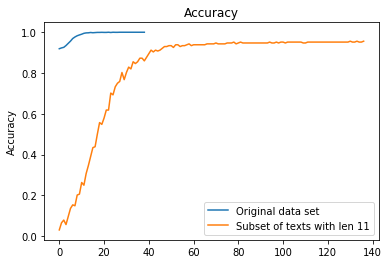

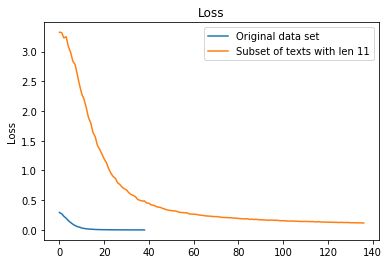

In [25]:
plt.plot(hist10.history['val_accuracy'], label='Original data set')
plt.plot(hist10_with_size_11.history['val_accuracy'], label='Subset of texts with len 11')
plt.title('Accuracy')
plt.ylabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="best")
axes = plt.gca()
plt.show()

plt.plot(hist10.history['val_loss'], label='Original data set')
plt.plot(hist10_with_size_11.history['val_loss'], label='Subset of texts with len 11')
plt.title('Loss')
plt.ylabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

The trend looks as expected, less data did result in less progress in both accuracy and lost. Let's see how the last 20 epochs behave in both cases:

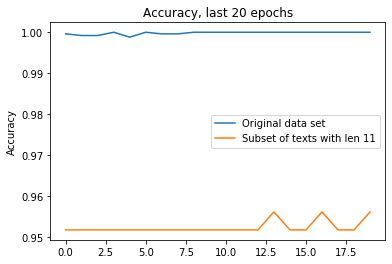

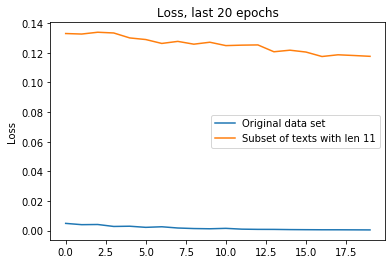

In [26]:
plt.plot(hist10.history['val_accuracy'][-20:], label='Original data set')
plt.plot(hist10_with_size_11.history['val_accuracy'][-20:], label='Subset of texts with len 11')
plt.title('Accuracy, last 20 epochs')
plt.ylabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="best")
axes = plt.gca()
plt.show()

plt.plot(hist10.history['val_loss'][-20:], label='Original data set')
plt.plot(hist10_with_size_11.history['val_loss'][-20:], label='Subset of texts with len 11')
plt.title('Loss, last 20 epochs')
plt.ylabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

Not good. The set of 11 length texts is too small to achieve the original performance.

To completely proof this idea, a new dataset could be generated. This dataset has twice more samples, comparing to previous runs.

In [27]:
(training_data11, training_labels11) = generate_dataset(int(50000/11*2), min_size=11, max_size=11) # original dataset size was 50000/11 - 50k samples uniformly distributed over sizes 1..11
training_labels11_char10 = make_labels_for_position(training_labels11, 10)
model = define_char_classifier()
hist10_with_size_11_2x = train_model(model, training_data11, training_labels11_char10, epochs=150)

Generating
Done: 10.0 %
Done: 20.0 %
Done: 30.0 %
Done: 40.0 %
Done: 50.0 %
Done: 60.0 %
Done: 70.0 %
Done: 80.0 %
Done: 90.0 %
Done: 100 %
Train on 8635 samples, validate on 455 samples
Epoch 1/150
8635/8635 [==============================] - 1s 117us/sample - loss: 3.3309 - accuracy: 0.0491 - val_loss: 3.3035 - val_accuracy: 0.0440
Epoch 2/150
8635/8635 [==============================] - 0s 51us/sample - loss: 3.1605 - accuracy: 0.0990 - val_loss: 3.1738 - val_accuracy: 0.0945
Epoch 3/150
8635/8635 [==============================] - 0s 51us/sample - loss: 2.9574 - accuracy: 0.1634 - val_loss: 2.9456 - val_accuracy: 0.1604
Epoch 4/150
8635/8635 [==============================] - 0s 55us/sample - loss: 2.6786 - accuracy: 0.2327 - val_loss: 2.7075 - val_accuracy: 0.2154
Epoch 5/150
8635/8635 [==============================] - 1s 64us/sample - loss: 2.3789 - accuracy: 0.3032 - val_loss: 2.3894 - val_accuracy: 0.2945
Epoch 6/150
8635/8635 [==============================] - 1s 63us/sample 

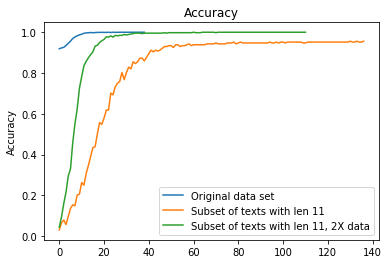

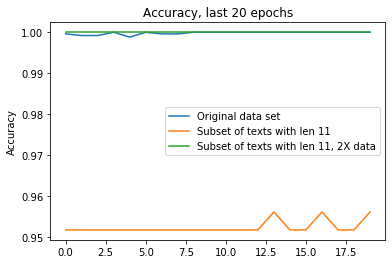

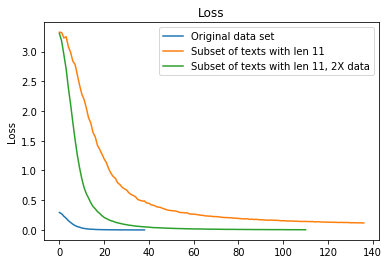

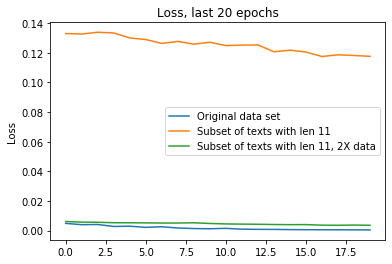

In [28]:
# plot the original data, the previous set of 11 sized texts and the last one, with twice more data
plt.plot(hist10.history['val_accuracy'], label='Original data set')
plt.plot(hist10_with_size_11.history['val_accuracy'], label='Subset of texts with len 11')
plt.plot(hist10_with_size_11_2x.history['val_accuracy'], label='Subset of texts with len 11, 2X data')
plt.title('Accuracy')
plt.ylabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.show()

plt.plot(hist10.history['val_accuracy'][-20:], label='Original data set')
plt.plot(hist10_with_size_11.history['val_accuracy'][-20:], label='Subset of texts with len 11')
plt.plot(hist10_with_size_11_2x.history['val_accuracy'][-20:], label='Subset of texts with len 11, 2X data')
plt.title('Accuracy, last 20 epochs')
plt.ylabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.show()

plt.plot(hist10.history['val_loss'], label='Original data set')
plt.plot(hist10_with_size_11.history['val_loss'], label='Subset of texts with len 11')
plt.plot(hist10_with_size_11_2x.history['val_loss'], label='Subset of texts with len 11, 2X data')
plt.title('Loss')
plt.ylabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

plt.plot(hist10.history['val_loss'][-20:], label='Original data set')
plt.plot(hist10_with_size_11.history['val_loss'][-20:], label='Subset of texts with len 11')
plt.plot(hist10_with_size_11_2x.history['val_loss'][-20:], label='Subset of texts with len 11, 2X data')
plt.title('Loss, last 20 epochs')
plt.ylabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

The performance of the model with twice more data is very good. Time to try a different network design.

### 4.2 Better NN design

The original network has a single hidden layer. The NN may not be flexible enough to recognize all classes correctly. Let's try to add one more hidden layer and train the network bases on the original data set.

In [29]:
# a new model with extra hidden layer
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(21, 21)),
    keras.layers.Dense(21*21, activation='relu'),
    keras.layers.Dense(21*21, activation='relu'), # extra layer
    keras.layers.Dense(len(ALL_CHAR_CLASSES))
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

hist10_deep = model.fit(
        training_data, np.asarray(training_labels_char10),
        epochs=150, batch_size=128,
        validation_split=0.05,
        callbacks=[EarlyStopping(monitor='val_loss' , min_delta=0.0001, patience=3)])

Train on 47500 samples, validate on 2500 samples
Epoch 1/150
47500/47500 [==============================] - 4s 81us/sample - loss: 0.3791 - accuracy: 0.9089 - val_loss: 0.2756 - val_accuracy: 0.9184
Epoch 2/150
47500/47500 [==============================] - 3s 72us/sample - loss: 0.2769 - accuracy: 0.9172 - val_loss: 0.2327 - val_accuracy: 0.9264
Epoch 3/150
47500/47500 [==============================] - 4s 82us/sample - loss: 0.2136 - accuracy: 0.9278 - val_loss: 0.1631 - val_accuracy: 0.9400
Epoch 4/150
47500/47500 [==============================] - 4s 77us/sample - loss: 0.1277 - accuracy: 0.9526 - val_loss: 0.0929 - val_accuracy: 0.9612
Epoch 5/150
47500/47500 [==============================] - 4s 82us/sample - loss: 0.0586 - accuracy: 0.9799 - val_loss: 0.0290 - val_accuracy: 0.9944
Epoch 6/150
47500/47500 [==============================] - 4s 83us/sample - loss: 0.0131 - accuracy: 0.9983 - val_loss: 0.0410 - val_accuracy: 0.9920
Epoch 7/150
47500/47500 [==========================

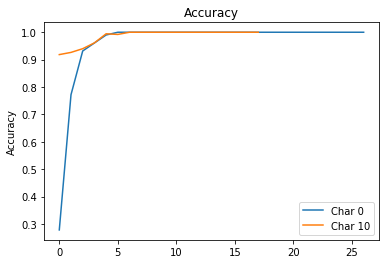

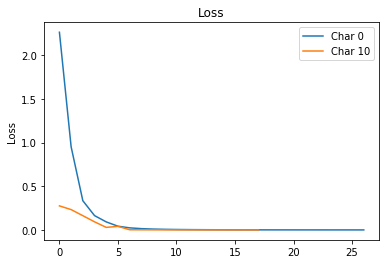

In [30]:
plt.plot(hist0.history['val_accuracy'], label='Char 0')
plt.plot(hist10_deep.history['val_accuracy'], label='Char 10')
plt.title('Accuracy')
plt.ylabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.show()

plt.plot(hist0.history['val_loss'], label='Char 0')
plt.plot(hist10_deep.history['val_loss'], label='Char 10')
plt.title('Loss')
plt.ylabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

Outstanding result. In fact, the new design for the last char performs as good as the old one for the first char.

## 4. Build a set of NNs to decode QR codes

The goal for this part is to build 11 NNs. One for each position. For simplicity, the double hidden layer design is applied for every character.

In [31]:
# function to create and train 11 NNs, one per positions
# output is a set of models and train histories
def make_model_per_position(train, labels, epochs=150):
    models_per_position = []
    histories = []
    for position in range(11):
        print("Training for position:", position)
        train_labels_chars = make_labels_for_position(labels, position) # generate labels for specific position
        model = keras.Sequential([
                                keras.layers.Flatten(input_shape=(21, 21)),
                                keras.layers.Dense(21*21, activation='relu'),
                                keras.layers.Dense(21*21, activation='relu'),
                                keras.layers.Dense(len(ALL_CHAR_CLASSES))
                                ])
        model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
        history = train_model(model, train, train_labels_chars, epochs)
        models_per_position.append(keras.Sequential([model, keras.layers.Softmax()])) # each trained model is augmented with  a softmax layer for easier results interpretation
        histories.append(history)
    return (models_per_position, histories)

# creating 11 NNs using original 50k dataset
(models_per_position, histories) = make_model_per_position(training_data, training_labels)

Training for position: 0
Train on 47500 samples, validate on 2500 samples
Epoch 1/150
47500/47500 [==============================] - 4s 79us/sample - loss: 2.1614 - accuracy: 0.3376 - val_loss: 0.3508 - val_accuracy: 0.9200
Epoch 2/150
47500/47500 [==============================] - 3s 70us/sample - loss: 0.0541 - accuracy: 0.9957 - val_loss: 0.0078 - val_accuracy: 1.0000
Epoch 3/150
47500/47500 [==============================] - 4s 81us/sample - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 4/150
47500/47500 [==============================] - 4s 82us/sample - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 5/150
47500/47500 [==============================] - 4s 82us/sample - loss: 9.9950e-04 - accuracy: 1.0000 - val_loss: 8.0182e-04 - val_accuracy: 1.0000
Epoch 6/150
47500/47500 [==============================] - 4s 77us/sample - loss: 6.0850e-04 - accuracy: 1.0000 - val_loss: 5.1275e-04 - val_accuracy: 1.0000
Epoch 7/15

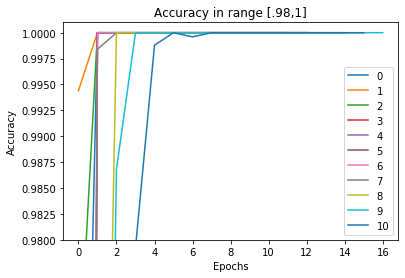

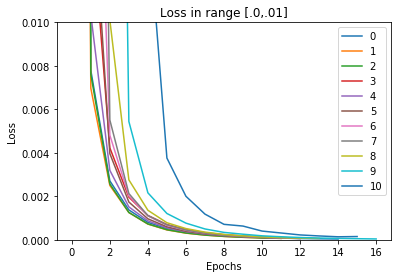

In [32]:
# plot every loss and accuracy
pos = 0
for h in histories:
    plt.plot(h.history['val_accuracy'], label=str(pos))
    pos += 1
plt.title("Accuracy in range [.98,1]")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="lower right")
plt.gca().axes.set_ylim([.98,1.001]) # set limits to zoom in into meaningful data
plt.show()

pos = 0
for h in histories:
    plt.plot(h.history['val_loss'], label=str(pos))
    pos += 1
plt.title('Loss in range [.0,.01]')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper right")
plt.gca().axes.set_ylim([.0,.01]) # set limits to zoom in into meaningful data
plt.show()

As expected, every larger position performs a bit worse, since the dataset has less and less well-distributed samples per position. Let's try to decide a few QR codes and see how accuracy and confidence behaves:

In [33]:
# print each letter from a QR code with confidence level
def predict_qr(s, qr_code, models):
    print("--------------")
    for i in range(11):
        expected_char = s[i] if i < len(s) else EOI
        (c, confidence, all) = get_letter(qr_code, models[i])
        print(c == expected_char, "Predicted:", c, "Expected:", expected_char, "Confidence:", confidence)

[predict_qr(s, make_qr(s), models_per_position) for s in ["hello world"]]
[predict_qr(s, make_qr(s), models_per_position) for s in ["machine ai"]]
[predict_qr(s, make_qr(s), models_per_position) for s in ["joe"]]
[predict_qr(s, make_qr(s), models_per_position) for s in ["iddqd"]]
[predict_qr(s, make_qr(s), models_per_position) for s in ["longer str"]]
[predict_qr(s, make_qr(s), models_per_position) for s in ["may fail at"]]
[predict_qr(s, make_qr(s), models_per_position) for s in ["data master"]]
[predict_qr(s, make_qr(s), models_per_position) for s in ["iddqd quake"]]
[predict_qr(s, make_qr(s), models_per_position) for s in ["datamatters"]]

--------------
True Predicted: h Expected: h Confidence: 0.99994385
True Predicted: e Expected: e Confidence: 0.9999453
True Predicted: l Expected: l Confidence: 0.99992955
True Predicted: l Expected: l Confidence: 0.99993896
True Predicted: o Expected: o Confidence: 0.99990535
True Predicted:   Expected:   Confidence: 0.9999378
True Predicted: w Expected: w Confidence: 0.99981326
True Predicted: o Expected: o Confidence: 0.999902
True Predicted: r Expected: r Confidence: 0.99974626
True Predicted: l Expected: l Confidence: 0.9998753
True Predicted: d Expected: d Confidence: 0.9994261
--------------
True Predicted: m Expected: m Confidence: 0.9999678
True Predicted: a Expected: a Confidence: 0.99994326
True Predicted: c Expected: c Confidence: 0.9999323
True Predicted: h Expected: h Confidence: 0.99995327
True Predicted: i Expected: i Confidence: 0.99989593
True Predicted: n Expected: n Confidence: 0.999923
True Predicted: e Expected: e Confidence: 0.9999316
True Predicted:   Expected:

[None]

To run one more test, we can take 10k of the most popular English words and try NNs on them. Get this repo: https://github.com/first20hours/google-10000-english and update the path below. The code will load each word and trim longer ones to have the first 11 characters.

In [34]:
GOOGLE_10000_WORDS = 'google-10000-english-no-swears.txt' # update path to the file
with open(GOOGLE_10000_WORDS, 'r') as f:
    words10000 = f.readlines()

words11_data = [] # QR codes
words11 = [] # text labels
for w in words10000:
    label = w.strip()[:11]
    if len(label) == 0:
        continue
    words11.append(label)
    img = make_qr(label)
    assert img.size == (21, 21)
    words11_data.append(np.asarray(img, dtype='float'))
words11_data = np.asarray(words11_data)

In [35]:
# run the NN against all QR codes and remember texts with errors
# since we have separate networks per position, results are also per position
def run_words_with_individual_models():
    wrong_words = []
    for pos in range(11): # apply one model per position
        smallest_confidence = 1
        model = models_per_position[pos]
        output = model.predict(words11_data)
        correct = 0
        for i in range(len(output)):
            expected_char = words11[i][pos] if pos < len(words11[i]) else EOI # if text is shorter than 11, tail characters are '#'
            largest_index = np.argmax(output[i], axis=0)
            smallest_confidence = min(smallest_confidence, output[i][largest_index])
            predicred_char = ALL_CHAR_CLASSES[largest_index]
            if predicred_char == expected_char:
                correct += 1
            else:
                wrong_words.append(words11[i])
        print("Pos", pos, "Correct", correct/len(words11_data), "Mis. count:", len(words11_data) - correct, "Smallest confidence:", smallest_confidence)
    return wrong_words
wrong_words = run_words_with_individual_models()

Pos 0 Correct 1.0 Mis. count: 0 Smallest confidence: 0.9994931
Pos 1 Correct 1.0 Mis. count: 0 Smallest confidence: 0.99438184
Pos 2 Correct 1.0 Mis. count: 0 Smallest confidence: 0.9983413
Pos 3 Correct 1.0 Mis. count: 0 Smallest confidence: 0.9883525
Pos 4 Correct 1.0 Mis. count: 0 Smallest confidence: 0.98402286
Pos 5 Correct 1.0 Mis. count: 0 Smallest confidence: 0.98981196
Pos 6 Correct 1.0 Mis. count: 0 Smallest confidence: 0.9919063
Pos 7 Correct 1.0 Mis. count: 0 Smallest confidence: 0.9950441
Pos 8 Correct 1.0 Mis. count: 0 Smallest confidence: 0.9915815
Pos 9 Correct 1.0 Mis. count: 0 Smallest confidence: 0.97259146
Pos 10 Correct 1.0 Mis. count: 0 Smallest confidence: 0.97291905


At this time we should have 100% accuracy. The last column is the smallest confidence per position. A high number is great.

## 5. Build single NN to decode QR codes

So far we have trained eleven individual NNs to decode symbols of a QR code one by one. Seems like a lot of networks to manage. It makes sense to join NNs to one.

The intent is to build one NN with 11 outputs:

In [36]:
# first recreate labels for all positions
training_label_sizes = list(map(lambda x: [len(x) - 1], training_labels))
training_labels_char0 = make_labels_for_position(training_labels, 0)
training_labels_char1 = make_labels_for_position(training_labels, 1)
training_labels_char2 = make_labels_for_position(training_labels, 2)
training_labels_char3 = make_labels_for_position(training_labels, 3)
training_labels_char4 = make_labels_for_position(training_labels, 4)
training_labels_char5 = make_labels_for_position(training_labels, 5)
training_labels_char6 = make_labels_for_position(training_labels, 6)
training_labels_char7 = make_labels_for_position(training_labels, 7)
training_labels_char8 = make_labels_for_position(training_labels, 8)
training_labels_char9 = make_labels_for_position(training_labels, 9)
training_labels_char10 = make_labels_for_position(training_labels, 10)

In [37]:
#                                                     |-> char 0 output
# INPUT -> FLATTEN -> HIDDEN LAYER1 -> HIDDEN LAYER2 -|-> ...
#                                                     |-> char 10 output
#
#
def define_multi_output_model():
    input_layer = keras.layers.Input(shape=(21,21,), dtype='float', name='input_qr')
    flatten = keras.layers.Flatten(input_shape=(21, 21), name='flatten')(input_layer)    
    hidden_chars1 = keras.layers.Dense(21*21, activation='relu', name='hidden_chars1')(flatten)
    hidden_chars2 = keras.layers.Dense(21*21, activation='relu', name='hidden_chars2')(hidden_chars1)
    
    outputs = []
    for i in range(11):
        char_output = keras.layers.Dense(len(ALL_CHAR_CLASSES), name='char' + str(i))(hidden_chars2)
        outputs.append(char_output)

    multi_output_model = keras.Model(inputs=[input_layer], outputs=outputs)
    
    multi_output_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return multi_output_model

mo_model = define_multi_output_model()
mo_model.summary()
mo_hist = mo_model.fit(
        training_data, [
            np.asarray(training_labels_char0),
            np.asarray(training_labels_char1),
            np.asarray(training_labels_char2),
            np.asarray(training_labels_char3),
            np.asarray(training_labels_char4),
            np.asarray(training_labels_char5),
            np.asarray(training_labels_char6),
            np.asarray(training_labels_char7),
            np.asarray(training_labels_char8),
            np.asarray(training_labels_char9),
            np.asarray(training_labels_char10)
        ],
        epochs=150, batch_size=128,
        validation_split=0.05,
        callbacks=[EarlyStopping(monitor='val_loss' , min_delta=0.0001, patience=3)]
    )

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_qr (InputLayer)           [(None, 21, 21)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 441)          0           input_qr[0][0]                   
__________________________________________________________________________________________________
hidden_chars1 (Dense)           (None, 441)          194922      flatten[0][0]                    
__________________________________________________________________________________________________
hidden_chars2 (Dense)           (None, 441)          194922      hidden_chars1[0][0]              
______________________________________________________________________________________________

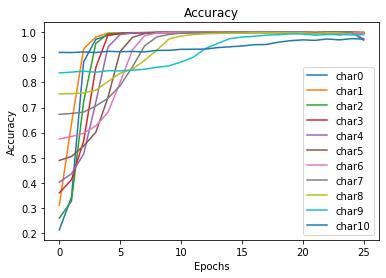

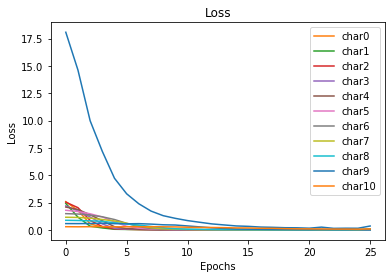

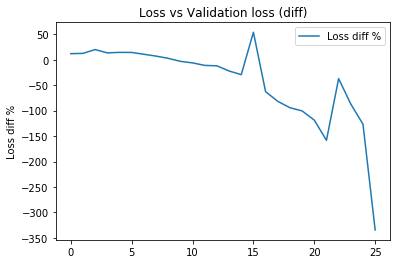

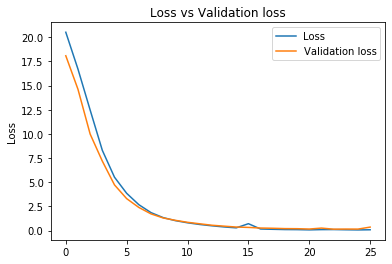

In [38]:
# plot every loss and accuracy

def plot_all_accuracy_and_loss(hist):
    for h in hist.history:
        if h.startswith('val_') and h.endswith('_accuracy'):
            plt.plot(hist.history[h], label=h[4:-9])
    plt.title("Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc="best")
    plt.show()

    for h in hist.history:
        if h.startswith('val_') and h.endswith('_loss'):
            plt.plot(hist.history[h], label=h[4:-5])
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc="best")
    plt.show()

plot_all_accuracy_and_loss(mo_hist)

# plot diff in loss and val_loss
plot_loss_vs_validation_loss_diff(mo_hist)
plot_loss_vs_validation_loss(mo_hist)

Bad news: the NN never arrived at the desired accuracy of 100%. The good news: there is no overfitting, hence the NN underfits. Probably due to design. Another red flag is the performance of the first character, it also did not arriver to 100%. Since all outputs influence the same layers during training, this is a hint for improving the design.

Let's try more an NN with more hidden layers:

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_qr (InputLayer)           [(None, 21, 21)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 441)          0           input_qr[0][0]                   
__________________________________________________________________________________________________
hidden_chars1 (Dense)           (None, 441)          194922      flatten[0][0]                    
__________________________________________________________________________________________________
hidden_chars2 (Dense)           (None, 441)          194922      hidden_chars1[0][0]              
____________________________________________________________________________________________

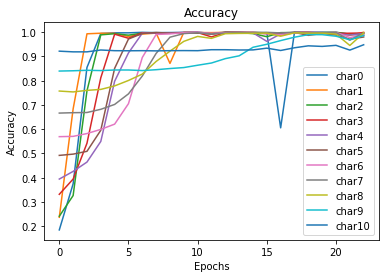

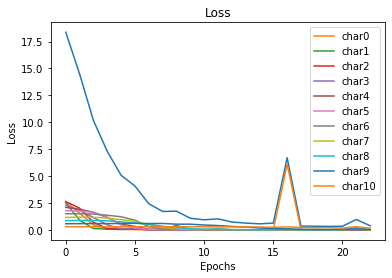

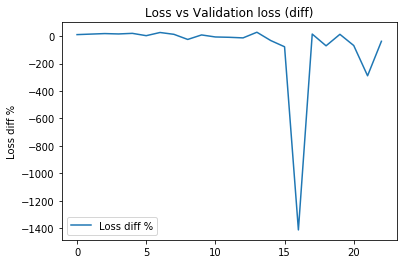

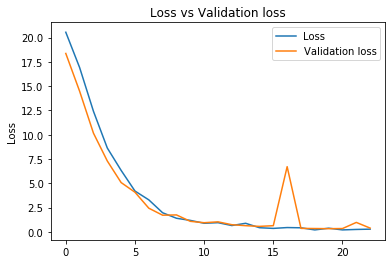

In [39]:
#                                       |-> char 0 output
# INPUT -> FLATTEN -> HIDDEN LAYER x 3 -|-> ...
#                                       |-> char 10 output
#
#
def define_deeper_multi_output_model():
    input_layer = keras.layers.Input(shape=(21,21,), dtype='float', name='input_qr')
    flatten = keras.layers.Flatten(input_shape=(21, 21), name='flatten')(input_layer)    
    hidden_chars1 = keras.layers.Dense(21*21, activation='relu', name='hidden_chars1')(flatten)
    hidden_chars2 = keras.layers.Dense(21*21, activation='relu', name='hidden_chars2')(hidden_chars1)
    hidden_chars3 = keras.layers.Dense(21*21, activation='relu', name='hidden_chars3')(hidden_chars2)
    
    outputs = []
    for i in range(11):
        char_output = keras.layers.Dense(len(ALL_CHAR_CLASSES), name='char' + str(i))(hidden_chars3)
        outputs.append(char_output)

    multi_output_model = keras.Model(inputs=[input_layer], outputs=outputs)
    
    multi_output_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return multi_output_model

mo_model = define_deeper_multi_output_model()
mo_model.summary()
mo_hist = mo_model.fit(
        training_data, [
            np.asarray(training_labels_char0),
            np.asarray(training_labels_char1),
            np.asarray(training_labels_char2),
            np.asarray(training_labels_char3),
            np.asarray(training_labels_char4),
            np.asarray(training_labels_char5),
            np.asarray(training_labels_char6),
            np.asarray(training_labels_char7),
            np.asarray(training_labels_char8),
            np.asarray(training_labels_char9),
            np.asarray(training_labels_char10)
        ],
        epochs=150, batch_size=128,
        validation_split=0.05,
        callbacks=[EarlyStopping(monitor='val_loss' , min_delta=0.0001, patience=3)]
    )

plot_all_accuracy_and_loss(mo_hist)
plot_loss_vs_validation_loss_diff(mo_hist)
plot_loss_vs_validation_loss(mo_hist)

Since more layers did make things worse for other positions, try to split layers per position.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_qr (InputLayer)           [(None, 21, 21)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 441)          0           input_qr[0][0]                   
__________________________________________________________________________________________________
hidden_chars1 (Dense)           (None, 441)          194922      flatten[0][0]                    
__________________________________________________________________________________________________
dense_46 (Dense)                (None, 441)          194922      hidden_chars1[0][0]              
____________________________________________________________________________________________

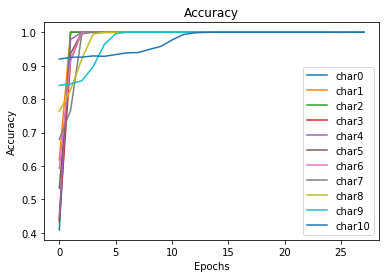

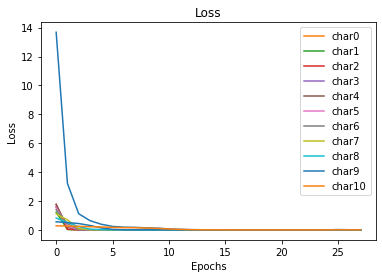

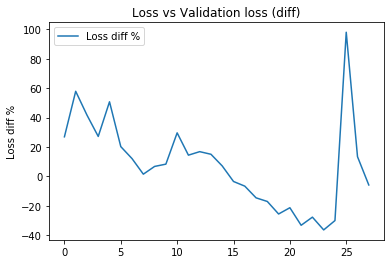

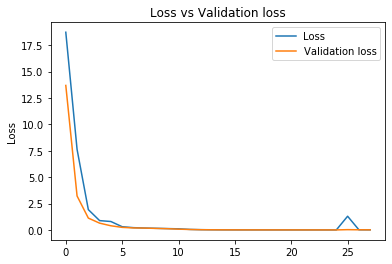

In [40]:
#                                   |-> HIDDEN LAYER -> char 0 output
# INPUT -> FLATTEN -> HIDDEN LAYER -|-> ...
#                                   |-> HIDDEN LAYER -> char 10 output
#
#
def define_split_multi_output_model():
    input_layer = keras.layers.Input(shape=(21,21,), dtype='float', name='input_qr')
    flatten = keras.layers.Flatten(input_shape=(21, 21), name='flatten')(input_layer)    
    hidden_chars1 = keras.layers.Dense(21*21, activation='relu', name='hidden_chars1')(flatten)
    
    outputs = []
    for i in range(11):
        hidden_chars2 = keras.layers.Dense(21*21, activation='relu')(hidden_chars1)
        char_output = keras.layers.Dense(len(ALL_CHAR_CLASSES), name='char' + str(i))(hidden_chars2)
        outputs.append(char_output)

    multi_output_model = keras.Model(inputs=[input_layer], outputs=outputs)
    
    multi_output_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return multi_output_model

mo_model = define_split_multi_output_model()
mo_model.summary()
mo_hist = mo_model.fit(
        training_data, [
            np.asarray(training_labels_char0),
            np.asarray(training_labels_char1),
            np.asarray(training_labels_char2),
            np.asarray(training_labels_char3),
            np.asarray(training_labels_char4),
            np.asarray(training_labels_char5),
            np.asarray(training_labels_char6),
            np.asarray(training_labels_char7),
            np.asarray(training_labels_char8),
            np.asarray(training_labels_char9),
            np.asarray(training_labels_char10)
        ],
        epochs=150, batch_size=128,
        validation_split=0.05,
        callbacks=[EarlyStopping(monitor='val_loss' , min_delta=0.0001, patience=3)]
    )

plot_all_accuracy_and_loss(mo_hist)
plot_loss_vs_validation_loss_diff(mo_hist)
plot_loss_vs_validation_loss(mo_hist)

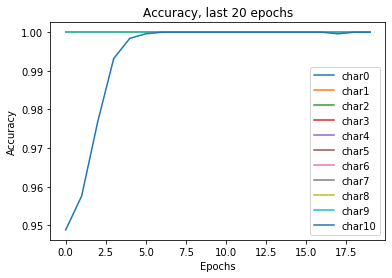

In [41]:
# let's zoom in into the tail of accuracy
for h in mo_hist.history:
    if h.startswith('val_') and h.endswith('_accuracy'):
        plt.plot(mo_hist.history[h][-20:], label=h[4:-9])
plt.title("Accuracy, last 20 epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.show()


In [42]:
# check how the best epoch looks like
best_epoch = np.argmin(mo_hist.history['val_loss'], axis=0)
print("Best epoch:", best_epoch, "out of", len(mo_hist.history['val_loss']))
for h in mo_hist.history:
    if h.startswith('val_'):
        print(h, mo_hist.history[h][best_epoch])

Best epoch: 24 out of 28
val_loss 0.0004742016372270882
val_char0_loss 1.254878e-05
val_char1_loss 1.1144185e-05
val_char2_loss 1.4638953e-05
val_char3_loss 2.2031929e-05
val_char4_loss 2.5994039e-05
val_char5_loss 1.9019555e-05
val_char6_loss 2.4395402e-05
val_char7_loss 2.4965897e-05
val_char8_loss 3.329939e-05
val_char9_loss 5.108057e-05
val_char10_loss 0.00023854862
val_char0_accuracy 1.0
val_char1_accuracy 1.0
val_char2_accuracy 1.0
val_char3_accuracy 1.0
val_char4_accuracy 1.0
val_char5_accuracy 1.0
val_char6_accuracy 1.0
val_char7_accuracy 1.0
val_char8_accuracy 1.0
val_char9_accuracy 1.0
val_char10_accuracy 1.0


The performance is pretty good.

We may give it a try and use the fact that size determination was working great.

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_qr (InputLayer)           [(None, 21, 21)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 441)          0           input_qr[0][0]                   
__________________________________________________________________________________________________
hidden_size (Dense)             (None, 441)          194922      flatten[0][0]                    
__________________________________________________________________________________________________
size_output (Dense)             (None, 11)           4862        hidden_size[0][0]                
____________________________________________________________________________________________

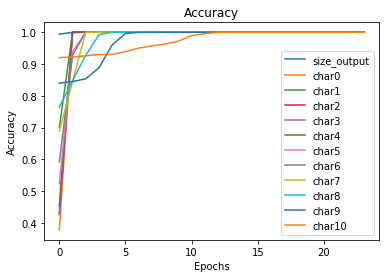

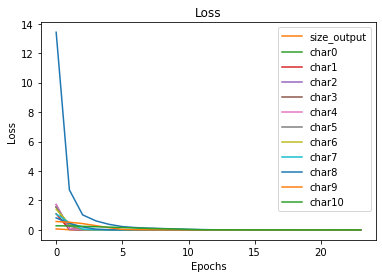

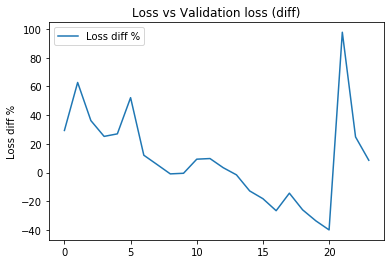

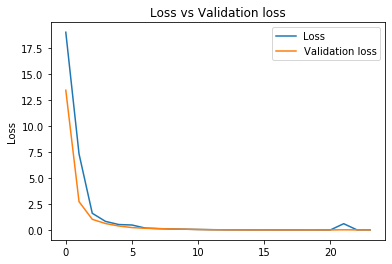

In [44]:
#
# INPUT -> FLATTEN -> HIDDEN_CHARS ->| for every char take both HIDDEN_CHARS and SIZE
#                  -> HIDDEN_SIZE -> 11 CLASSES(one per size)
#


def define_split_with_size_multi_output_model():
    input_layer = keras.layers.Input(shape=(21,21,), dtype='float', name='input_qr')
    flatten = keras.layers.Flatten(input_shape=(21, 21), name='flatten')(input_layer)    
    hidden_chars1 = keras.layers.Dense(21*21, activation='relu', name='hidden_chars1')(flatten)
    hidden_size = keras.layers.Dense(21*21, activation='relu', name='hidden_size')(flatten)
    size_output = keras.layers.Dense(MAX_SIZE, name='size_output')(hidden_size)
    
    # stop back propagation since size is independent from actual characters
    size_without_more_optimizations = tf.stop_gradient(size_output, name='size_wo_gradient')
    
    outputs = [size_output]
    for i in range(11):
        hidden_chars2 = keras.layers.Dense(21*21, activation='relu')(hidden_chars1)
        combined_char_inputs = keras.layers.concatenate([hidden_chars2, size_without_more_optimizations])
        char_output = keras.layers.Dense(len(ALL_CHAR_CLASSES), name='char' + str(i))(combined_char_inputs)
        outputs.append(char_output)

    multi_output_model = keras.Model(inputs=[input_layer], outputs=outputs)
    
    multi_output_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return multi_output_model

mo_model = define_split_with_size_multi_output_model()
mo_model.summary()
mo_hist = mo_model.fit(
        training_data, [
            np.asarray(training_label_sizes),
            np.asarray(training_labels_char0),
            np.asarray(training_labels_char1),
            np.asarray(training_labels_char2),
            np.asarray(training_labels_char3),
            np.asarray(training_labels_char4),
            np.asarray(training_labels_char5),
            np.asarray(training_labels_char6),
            np.asarray(training_labels_char7),
            np.asarray(training_labels_char8),
            np.asarray(training_labels_char9),
            np.asarray(training_labels_char10)
        ],
        epochs=150, batch_size=128,
        validation_split=0.05,
        callbacks=[EarlyStopping(monitor='val_loss' , min_delta=0.0001, patience=3)]
    )

plot_all_accuracy_and_loss(mo_hist)
plot_loss_vs_validation_loss_diff(mo_hist)
plot_loss_vs_validation_loss(mo_hist)

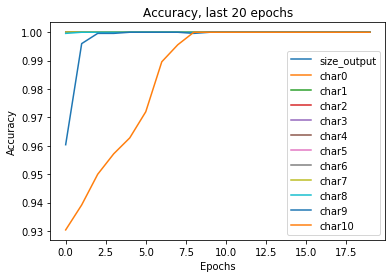

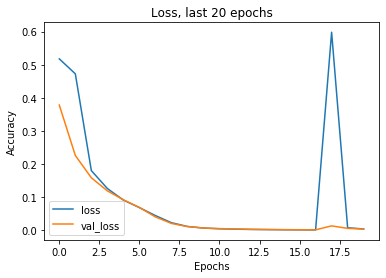

In [45]:
# let's zoom in into the tail of accuracy
for h in mo_hist.history:
    if h.startswith('val_') and h.endswith('_accuracy'):
        plt.plot(mo_hist.history[h][-20:], label=h[4:-9])
plt.title("Accuracy, last 20 epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.show()


# let's zoom in into the tail of loss
plt.plot(mo_hist.history['loss'][-20:], label='loss')
plt.plot(mo_hist.history['val_loss'][-20:], label='val_loss')
plt.title("Loss, last 20 epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.show()


## FINAL model
Since the last model workes great, let's retrain it with checkpoint savings

In [46]:
mo_model = define_split_with_size_multi_output_model()
mo_model.summary()
mo_hist = mo_model.fit(
        training_data, [
            np.asarray(training_label_sizes),
            np.asarray(training_labels_char0),
            np.asarray(training_labels_char1),
            np.asarray(training_labels_char2),
            np.asarray(training_labels_char3),
            np.asarray(training_labels_char4),
            np.asarray(training_labels_char5),
            np.asarray(training_labels_char6),
            np.asarray(training_labels_char7),
            np.asarray(training_labels_char8),
            np.asarray(training_labels_char9),
            np.asarray(training_labels_char10)
        ],
        epochs=150, batch_size=128,
        validation_split=0.05,
        callbacks=[
            EarlyStopping(monitor='val_loss' , min_delta=0.0001, patience=3),
            ModelCheckpoint(filepath='qr-ffnn.h5', monitor='val_loss', save_best_only=True, verbose=1)
        ]
    )

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_qr (InputLayer)           [(None, 21, 21)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 441)          0           input_qr[0][0]                   
__________________________________________________________________________________________________
hidden_size (Dense)             (None, 441)          194922      flatten[0][0]                    
__________________________________________________________________________________________________
size_output (Dense)             (None, 11)           4862        hidden_size[0][0]                
____________________________________________________________________________________________

In [47]:
# load best model
best_model = keras.models.load_model('qr-ffnn.h5')

In [49]:
# try on most popular words
predictions = best_model.predict(words11_data)

def softmax(values):
    exp = np.exp(values - np.max(values))
    return exp / exp.sum()

errors = 0
conf = 1
for i in range(len(words11)):
    expected_word = words11[i].ljust(11, EOI)
    predicted_chars = []
    for k in range(1, 12):
        largest_index = np.argmax(predictions[k][i], axis=0)
        c = ALL_CHAR_CLASSES[largest_index]
        predicted_chars.append(c)
    predicted_word = ''.join(predicted_chars)
    if expected_word != predicted_word:
        errors += 1
        print(i)
        print(expected_word)
        print(predicted_word)
print("Total errors:", errors, "out of", len(words11))

48
information
informatiof
5836
information
informatiof
9112
workstation
workstatiof
Total errors: 3 out of 9894


3 errors out of almost 10k - this is a pretty good solution.

# Try recurrent neural network (RNN)

QR code may be seen as a stream of characters. Every next one may depend on previous output. It makes sense to try RNN and see how it will behave.

In [55]:
# simple RNN with 3 LSTM layers. Output is 11 classes.
def make_rnn():

    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(21,21)))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.RepeatVector(11))
    model.add(keras.layers.LSTM(21*21, return_sequences=True))
    model.add(keras.layers.LSTM(21*21, return_sequences=True))
    model.add(keras.layers.LSTM(21, return_sequences=True))
    model.add(keras.layers.TimeDistributed(keras.layers.Dense(len(ALL_CHAR_CLASSES))))
    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    return model

rnn = make_rnn()
rnn.summary()

Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 441)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 11, 441)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 11, 441)           1557612   
_________________________________________________________________
lstm_1 (LSTM)                (None, 11, 441)           1557612   
_________________________________________________________________
lstm_2 (LSTM)                (None, 11, 21)            38892     
_________________________________________________________________
time_distributed (TimeDistri (None, 11, 28)            616       
Total params: 3,154,732
Trainable params: 3,154,732
Non-trainable params: 0
___________________________________________

In [56]:
# create labels for RNN
# labels must have 11 classes, one per each position
rnn_labels = []
for label in training_labels:
    label_matrix = []
    for i in range(11):
        c = label[i] if len(label) > i else EOI
        label_matrix.append([ALL_CHAR_CLASSES.index(c)])
    rnn_labels.append(label_matrix)
rnn_labels = np.asarray(rnn_labels)

In [57]:
#train_data, train_labels
rnn_labels.shape

(50000, 11, 1)

In [67]:
rnn_hist = rnn.fit(
        training_data,
        rnn_labels,
        epochs=150,
        batch_size=128,
        validation_split=0.05,
        callbacks=[EarlyStopping(monitor='val_loss' , min_delta=0.0001, patience=3)]
    )

Train on 47500 samples, validate on 2500 samples
Epoch 1/150
47500/47500 [==============================] - 150s 3ms/sample - loss: 1.4395 - accuracy: 0.5210 - val_loss: 1.3092 - val_accuracy: 0.5425
Epoch 2/150
47500/47500 [==============================] - 165s 3ms/sample - loss: 1.3053 - accuracy: 0.5395 - val_loss: 1.1978 - val_accuracy: 0.5624
Epoch 3/150
47500/47500 [==============================] - 141s 3ms/sample - loss: 1.1711 - accuracy: 0.5690 - val_loss: 1.0711 - val_accuracy: 0.6024
Epoch 4/150
47500/47500 [==============================] - 139s 3ms/sample - loss: 1.0013 - accuracy: 0.6194 - val_loss: 0.8846 - val_accuracy: 0.6553
Epoch 5/150
47500/47500 [==============================] - 142s 3ms/sample - loss: 0.8064 - accuracy: 0.6732 - val_loss: 0.7353 - val_accuracy: 0.6890
Epoch 6/150
47500/47500 [==============================] - 142s 3ms/sample - loss: 0.6457 - accuracy: 0.7094 - val_loss: 0.5541 - val_accuracy: 0.7342
Epoch 7/150
47500/47500 [====================

Final accuracy is .9981, not as good as last FFNN, but not terribly bad either. Let's see performance on the dataset of most popular words:

In [69]:
output11 = rnn.predict(words11_data, batch_size=1)

In [71]:
# check every predicted label and count errors
def get_word_from_rnn_output(output, index):
    w = []
    for i in range(11):
        largest_index = np.argmax(output[index][i], axis=0)
        c = ALL_CHAR_CLASSES[largest_index]
        if c == EOI:
            break
        w.append(c)
    return ''.join(w)

errors = 0
error_samples = []
for i in range(len(words11)):
    actual = words11[i]
    predicted = get_word_from_rnn_output(output11, i)
    if actual != predicted:
        error_samples.append((actual, predicted))
        errors += 1
print("Errors:" , errors, errors/len(words11))
# print few samples
print(error_samples[:10])

Errors: 297 0.03001819284414797
[('these', 'thesg'), ('service', 'servkce'), ('state', 'statg'), ('system', 'systgm'), ('special', 'speckal'), ('download', 'downnoad'), ('library', 'librcry'), ('party', 'parts'), ('quote', 'quotg'), ('possible', 'posskble')]


The eventual error rate is 3% comparing to 0.03% of the best feed-forward neural network. It is much worse, but the network design is much simpler. One day I may spend more time applying an RNN to this problem.